In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Load dataset
df = pd.read_csv("student-mat.csv", sep=';')

In [3]:
# 1. Preprocessing
print("Missing values:\n", df.isnull().sum())

Missing values:
 school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64


In [4]:
# Encode categorical variables using OneHotEncoder
cat_features = df.select_dtypes(include=['object']).columns.tolist()
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_features.remove('G3')  # target

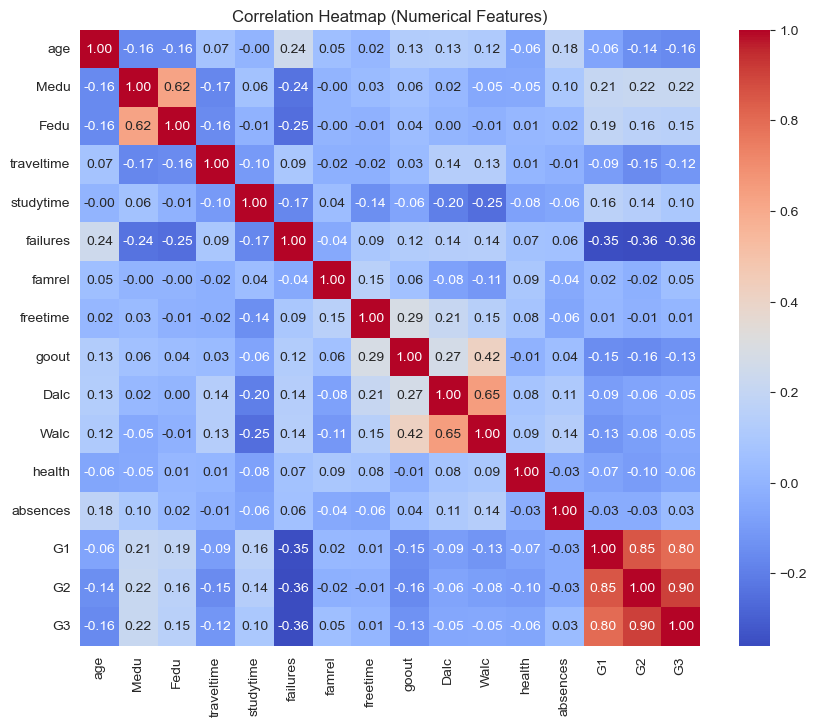

In [5]:
# Correlation heatmap (numeric only)
plt.figure(figsize=(10,8))
sns.heatmap(df[num_features + ['G3']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

In [6]:
# Prepare data
X = df.drop('G3', axis=1)
y = df['G3']

In [8]:
# Build preprocessing pipeline for categorical encoding and scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features)
    ])

In [9]:
# Transform features
X_processed = preprocessor.fit_transform(X)

# Convert processed features to DataFrame for convenience (optional)
encoded_cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
all_feature_names = num_features + list(encoded_cat_cols)
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_processed_df, y, test_size=0.3, random_state=42)

# 2. Simple Linear Regression (use G1 as single predictor)
X_train_g1 = X_train[['G1']]
X_test_g1 = X_test[['G1']]

lr_simple = LinearRegression()
lr_simple.fit(X_train_g1, y_train)
y_pred_simple = lr_simple.predict(X_test_g1)

# 3. Multiple Linear Regression (G1, G2, studytime, failures)
multi_features = ['G1', 'G2', 'studytime', 'failures']
lr_multi = LinearRegression()
lr_multi.fit(X_train[multi_features], y_train)
y_pred_multi = lr_multi.predict(X_test[multi_features])

# 4. SGD Regressor (using all features)
sgd = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd.fit(X_train, y_train)
y_pred_sgd = sgd.predict(X_test)

In [10]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} - R2: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")
    # Plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel('Actual G3')
    plt.ylabel('Predicted G3')
    plt.title(f'{model_name}: Actual vs Predicted')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')

    plt.subplot(1,2,2)
    residuals = y_true - y_pred
    plt.hist(residuals, bins=20)
    plt.title(f'{model_name}: Residuals Distribution')
    plt.xlabel('Residual')
    plt.tight_layout()
    plt.show()

Simple LR (G1) - R2: 0.6971, MSE: 6.6593, MAE: 1.8312


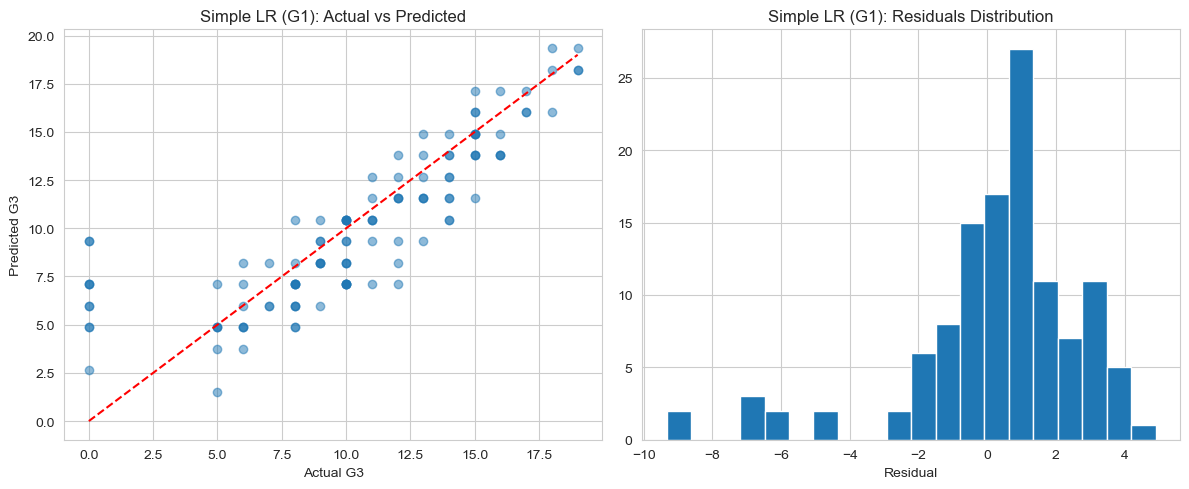

Multiple LR (G1, G2, studytime, failures) - R2: 0.7991, MSE: 4.4159, MAE: 1.2719


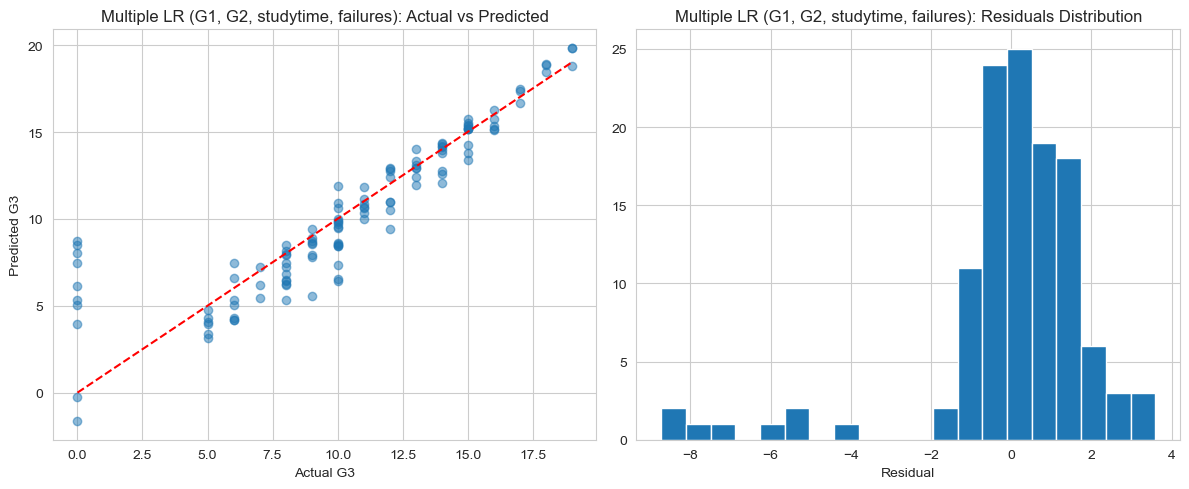

SGD Regressor (all features) - R2: 0.7619, MSE: 5.2335, MAE: 1.5828


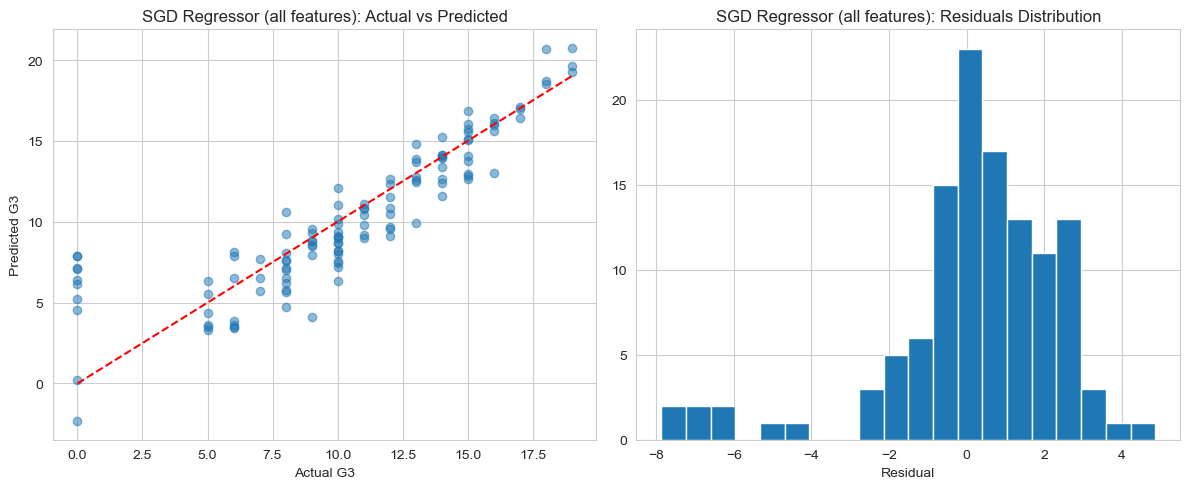

In [11]:
# Evaluate all models
evaluate_model(y_test, y_pred_simple, "Simple LR (G1)")
evaluate_model(y_test, y_pred_multi, "Multiple LR (G1, G2, studytime, failures)")
evaluate_model(y_test, y_pred_sgd, "SGD Regressor (all features)")

In [12]:
# Conclusion
print("""
Conclusion:
- The Multiple Linear Regression model using G1, G2, studytime, and failures performs better than the simple linear regression with G1 only, showing higher R2 and lower error metrics.
- The SGD Regressor, trained on all processed features, performs comparably to the OLS-based multiple regression but can be more scalable for very large datasets.
- SGD benefits from iterative optimization and can be tuned further with learning rate and regularization.
- Encoding categorical variables and scaling numeric features is critical for SGD performance.
""")


Conclusion:
- The Multiple Linear Regression model using G1, G2, studytime, and failures performs better than the simple linear regression with G1 only, showing higher R2 and lower error metrics.
- The SGD Regressor, trained on all processed features, performs comparably to the OLS-based multiple regression but can be more scalable for very large datasets.
- SGD benefits from iterative optimization and can be tuned further with learning rate and regularization.
- Encoding categorical variables and scaling numeric features is critical for SGD performance.

